In [1]:
# Environment & imports
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from sklearn.metrics import (
classification_report, confusion_matrix,
precision_recall_curve, roc_curve, auc,
precision_score, recall_score, f1_score
)


# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# Configuration
DATA_DIR = "drive/MyDrive/chest_xray" # adjust if needed
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Data loading with tf.keras utilities
train_ds = keras.utils.image_dataset_from_directory(
os.path.join(DATA_DIR, "train"),
labels="inferred",
label_mode="binary",
image_size=IMG_SIZE,
batch_size=BATCH_SIZE,
shuffle=True,
seed=SEED
)


val_ds = keras.utils.image_dataset_from_directory(
os.path.join(DATA_DIR, "val"),
labels="inferred",
label_mode="binary",
image_size=IMG_SIZE,
batch_size=BATCH_SIZE,
shuffle=False
)


test_ds = keras.utils.image_dataset_from_directory(
os.path.join(DATA_DIR, "test"),
labels="inferred",
label_mode="binary",
image_size=IMG_SIZE,
batch_size=BATCH_SIZE,
shuffle=False
)


class_names = train_ds.class_names
print("Classes:", class_names)


# Prefetch to improve performance
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


# Count samples (safe method)
def count_samples(dataset):
  return sum(1 for _ in dataset.unbatch())


n_train = count_samples(train_ds)
n_val = count_samples(val_ds)
n_test = count_samples(test_ds)
print(f"Samples -> train: {n_train}, val: {n_val}, test: {n_test}")

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Samples -> train: 5216, val: 16, test: 624


/tmp/ipython-input-229374742.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[i].numpy())])


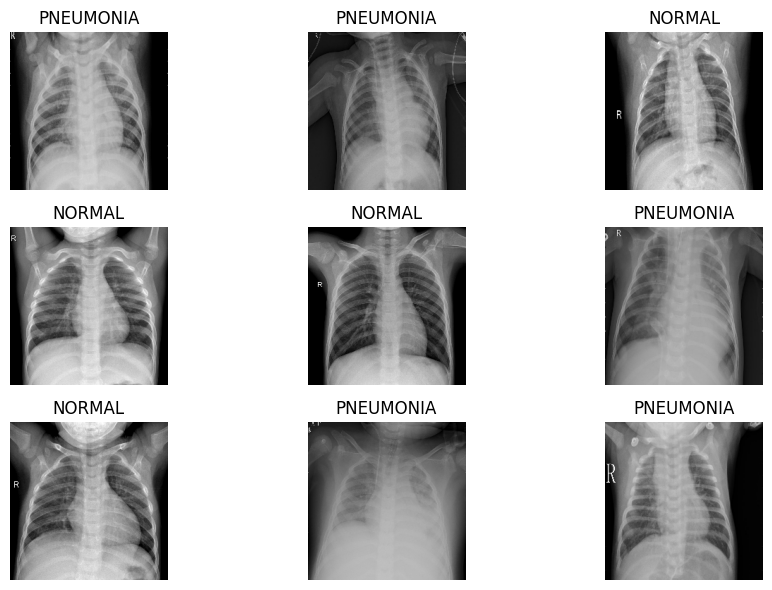

In [4]:
# Quick visual check of samples
images, labels = next(iter(train_ds.take(1)))
plt.figure(figsize=(10,6))
for i in range(min(9, images.shape[0])):
  plt.subplot(3,3,i+1)
  plt.imshow(images[i].numpy().astype('uint8'))
  plt.title(class_names[int(labels[i].numpy())])
  plt.axis('off')
plt.tight_layout()
plt.show()

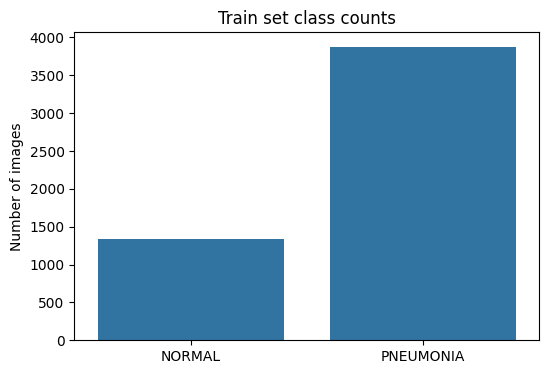

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [5]:
# Class distribution & class weights
train_normal = len(glob(os.path.join(DATA_DIR, 'train', 'NORMAL', '*')))
train_pneum = len(glob(os.path.join(DATA_DIR, 'train', 'PNEUMONIA', '*')))


plt.figure(figsize=(6,4))
sns.barplot(x=['NORMAL','PNEUMONIA'], y=[train_normal, train_pneum])
plt.title('Train set class counts')
plt.ylabel('Number of images')
plt.show()


# Compute class weights (robust: avoid division by zero)
total = train_normal + train_pneum
class_weight = {
0: total / (2 * train_normal) if train_normal else 1.0,
1: total / (2 * train_pneum) if train_pneum else 1.0
}
print('Class weights:', class_weight)

In [6]:
# Preprocessing & augmentation pipeline
augmentation = keras.Sequential([
layers.RandomFlip('horizontal'),
layers.RandomRotation(0.04),
layers.RandomZoom(0.08),
], name='augmentation')


# Rescaling is handled by model-specific preprocess_input below

In [7]:
# Build model using MobileNetV2 (transfer learning)
base_model = keras.applications.EfficientNetB0(
input_shape=IMG_SIZE + (3,),
include_top=False,
weights='imagenet'
)
base_model.trainable = False


inputs = keras.Input(shape=IMG_SIZE + (3,))
x = augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)


model = keras.Model(inputs, outputs)


model.compile(
optimizer=keras.optimizers.Adam(1e-3),
loss='binary_crossentropy',
metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.Recall(name='recall')]
)


model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
# Callbacks and initial training (feature extraction)
callbacks = [
keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=3, restore_best_weights=True),
keras.callbacks.ModelCheckpoint('best_feat.h5', monitor='val_auc', mode='max', save_best_only=True)
]


history = model.fit(
train_ds,
validation_data=val_ds,
epochs=8,
class_weight=class_weight,
callbacks=callbacks
)

Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8247 - auc: 0.9165 - loss: 0.4057 - recall: 0.8012

163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.8249 - auc: 0.9167 - loss: 0.4052 - recall: 0.8014 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2928 - val_recall: 1.0000
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8979 - auc: 0.9681 - loss: 0.2398 - recall: 0.8871 - val_accuracy: 0.9375 - val_auc: 0.9844 - val_loss: 0.2342 - val_recall: 1.0000
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9105 - auc: 0.9774 - loss: 0.2039 - recall: 0.8981

163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9105 - auc: 0.9774 - loss: 0.2039 - recall: 0.8982 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.2049 - val_recall: 1.0000
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.9228 - auc: 0.9817 - loss: 0.1814 - recall: 0.9150 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1740 - val_recall: 1.0000
Epoch 5/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9285 - auc: 0.9821 - loss: 0.1774 - recall: 0.9197 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1633 - val_recall: 1.0000
Epoch 6/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.9357 - auc: 0.9860 - loss: 0.1580 - recall: 0.9258 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1482 - val_recall: 1.0000


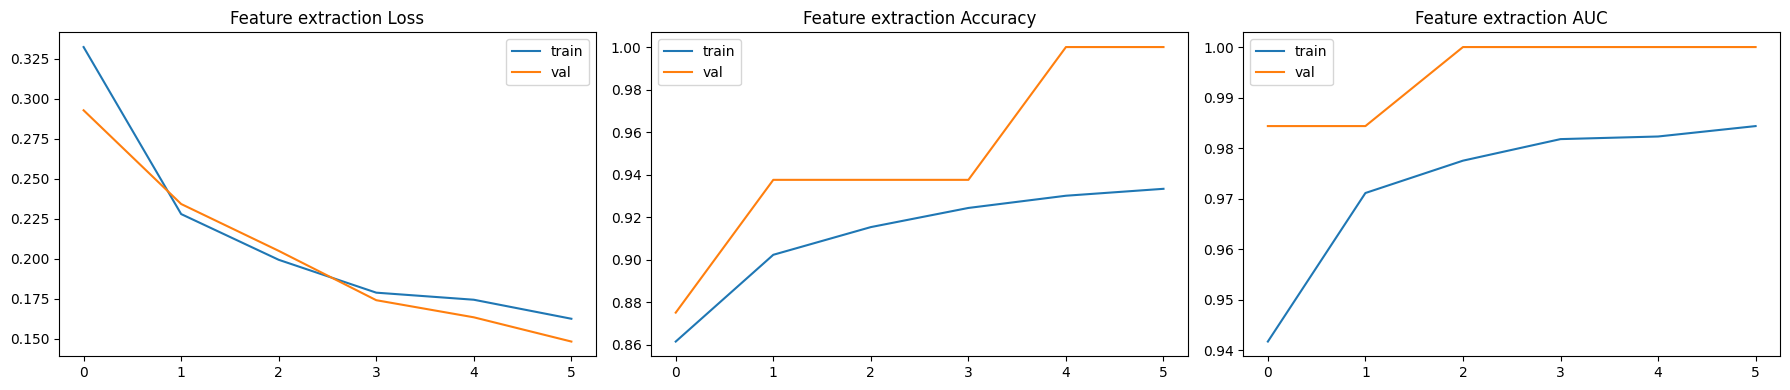

In [9]:
# Plot training history helper
def plot_history(hist, title_prefix=''):
  fig, axes = plt.subplots(1,3,figsize=(18,4))


  axes[0].plot(hist.history['loss'], label='train')
  axes[0].plot(hist.history['val_loss'], label='val')
  axes[0].set_title(title_prefix + ' Loss')
  axes[0].legend()


  axes[1].plot(hist.history['accuracy'], label='train')
  axes[1].plot(hist.history['val_accuracy'], label='val')
  axes[1].set_title(title_prefix + ' Accuracy')
  axes[1].legend()


  axes[2].plot(hist.history['auc'], label='train')
  axes[2].plot(hist.history['val_auc'], label='val')
  axes[2].set_title(title_prefix + ' AUC')
  axes[2].legend()


  plt.tight_layout()
  plt.show()


plot_history(history, 'Feature extraction')

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step
Classification report (0.5 threshold):
              precision    recall  f1-score   support

      NORMAL       0.86      0.68      0.76       234
   PNEUMONIA       0.83      0.94      0.88       390

    accuracy                           0.84       624
   macro avg       0.85      0.81      0.82       624
weighted avg       0.84      0.84      0.84       624



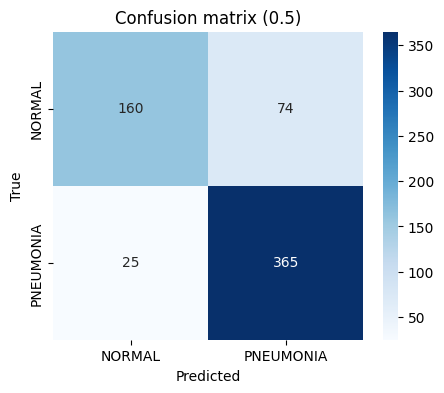

In [10]:
# Evaluate on test set (before fine-tuning)
# Gather true labels
y_true_test = np.concatenate([y for _, y in test_ds]).astype(int).ravel()
# Predict probabilities
y_prob_test = model.predict(test_ds).ravel()
y_pred_test = (y_prob_test >= 0.5).astype(int)


print('Classification report (0.5 threshold):')
print(classification_report(y_true_test, y_pred_test, target_names=class_names))


# Confusion matrix heatmap
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion matrix (0.5)')
plt.show()

Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5156 - auc: 0.5557 - loss: 0.7060 - recall: 0.4934

163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.5159 - auc: 0.5560 - loss: 0.7058 - recall: 0.4938 - val_accuracy: 0.5000 - val_auc: 0.5156 - val_loss: 0.7300 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6170 - auc: 0.6982 - loss: 0.6278 - recall: 0.5951

163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.6172 - auc: 0.6983 - loss: 0.6276 - recall: 0.5952 - val_accuracy: 0.6875 - val_auc: 0.7422 - val_loss: 0.6645 - val_recall: 0.3750 - learning_rate: 1.0000e-04
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6677 - auc: 0.7576 - loss: 0.5815 - recall: 0.6554

163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.6678 - auc: 0.7577 - loss: 0.5814 - recall: 0.6555 - val_accuracy: 0.6250 - val_auc: 0.7969 - val_loss: 0.6702 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7102 - auc: 0.8113 - loss: 0.5351 - recall: 0.6896

163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.7102 - auc: 0.8113 - loss: 0.5351 - recall: 0.6896 - val_accuracy: 0.6250 - val_auc: 0.8125 - val_loss: 0.6615 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.7201 - auc: 0.8260 - loss: 0.5125 - recall: 0.7050 - val_accuracy: 0.5625 - val_auc: 0.8047 - val_loss: 1.1347 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7498 - auc: 0.8532 - loss: 0.4757 - recall: 0.7264
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.7497 - auc: 0.8532 - loss: 0.4757 - recall: 0.7264 - val_accuracy: 0.5625 - val_auc: 0.7344 - val_loss: 2.0989 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7599 - auc: 0.8678 - loss: 0.4544 - recall: 0.7426

163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.7599 - auc: 0.8678 - loss: 0.4544 - recall: 0.7426 - val_accuracy: 0.6875 - val_auc: 0.8281 - val_loss: 0.7006 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 8/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.7841 - auc: 0.8833 - loss: 0.4325 - recall: 0.7622 - val_accuracy: 0.6250 - val_auc: 0.8281 - val_loss: 0.7513 - val_recall: 1.0000 - learning_rate: 5.0000e-05


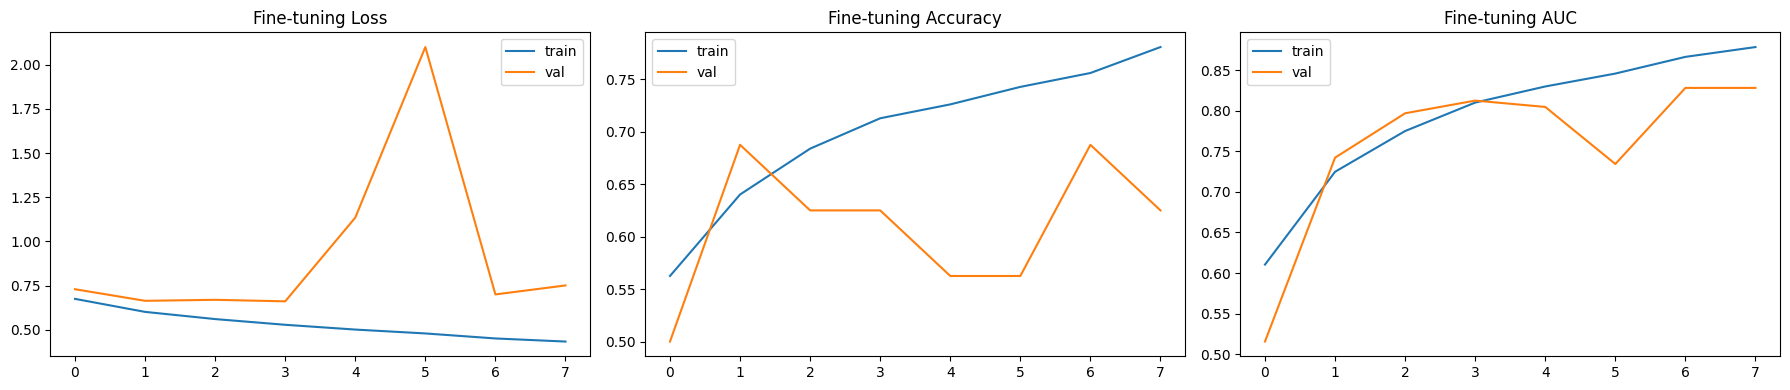

In [11]:
# Fine-tuning: gradual unfreeze and train with lower LR
# Strategy:
# - Unfreeze progressively (start with last 30 layers). If overfitting, unfreeze fewer layers.
# - Use a smaller learning rate and ReduceLROnPlateau to adapt LR during training.
# - Save the best weights.


# Choose how many layers to unfreeze (tweakable)
n_unfreeze = 30


# Freeze all then unfreeze last n_unfreeze
for layer in base_model.layers[:-n_unfreeze]:
  layer.trainable = False
for layer in base_model.layers[-n_unfreeze:]:
  layer.trainable = True


inputs = keras.Input(shape=IMG_SIZE + (3,))
x = augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)


model = keras.Model(inputs, outputs)


# Re-compile with lower learning rate
model.compile(
optimizer=keras.optimizers.Adam(1e-4),
loss='binary_crossentropy',
metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.Recall(name='recall')]
)


# Fine-tuning callbacks: early stopping, checkpoint, and LR scheduler
callbacks_ft = [
keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=3, restore_best_weights=True),
keras.callbacks.ModelCheckpoint('best_finetune.h5', monitor='val_auc', mode='max', save_best_only=True),
keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=2, verbose=1, min_lr=1e-7)
]


# Train (fine-tuning)
history_ft = model.fit(
train_ds,
validation_data=val_ds,
epochs=8,
class_weight=class_weight,
callbacks=callbacks_ft
)


# Plot fine-tuning history
plot_history(history_ft, 'Fine-tuning')

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step
Classification report (0.5 threshold):
              precision    recall  f1-score   support

      NORMAL       0.76      0.75      0.76       234
   PNEUMONIA       0.85      0.86      0.86       390

    accuracy                           0.82       624
   macro avg       0.81      0.80      0.81       624
weighted avg       0.82      0.82      0.82       624



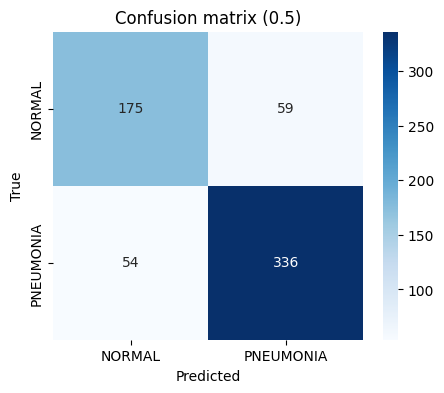

In [12]:
# Evaluation after fine-tuning
# Gather true labels
y_true_test = np.concatenate([y for _, y in test_ds]).astype(int).ravel()
# Predict probabilities
y_prob_test = model.predict(test_ds).ravel()
y_pred_test = (y_prob_test >= 0.5).astype(int)


print('Classification report (0.5 threshold):')
print(classification_report(y_true_test, y_pred_test, target_names=class_names))


# Confusion matrix heatmap
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion matrix (0.5)')
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
Best threshold (F1): 0.4727
Precision: 0.8345 | Recall: 0.8869 | F1: 0.8599 | ROC AUC: 0.8989


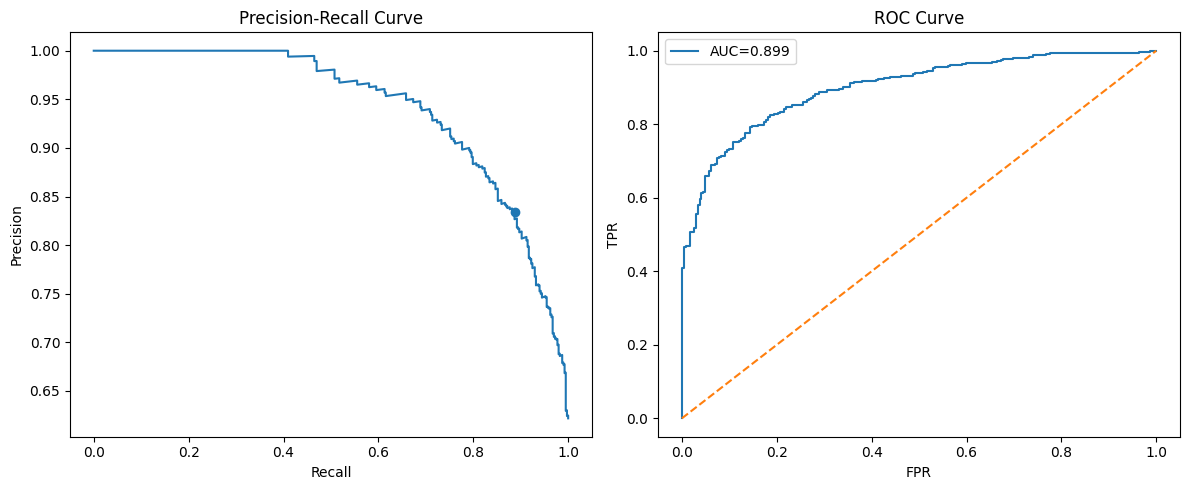

In [13]:
# Threshold tuning using validation + test combined for stability
combined_ds = val_ds.concatenate(test_ds)


y_true = np.concatenate([y for _, y in combined_ds]).astype(int).ravel()
y_prob = model.predict(combined_ds).ravel()


precisions, recalls, thresholds_pr = precision_recall_curve(y_true, y_prob)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thresholds_pr[best_idx] if best_idx < len(thresholds_pr) else 0.5


# ROC AUC
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)


# Apply best threshold and print metrics
y_pred = (y_prob >= best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Best threshold (F1): {best_thr:.4f}")
print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC AUC: {roc_auc:.4f}")


# Visualize PR and ROC
plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(recalls, precisions)
plt.scatter(recalls[best_idx], precisions[best_idx])
plt.title('Precision-Recall Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')


plt.subplot(1,2,2)
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()


plt.tight_layout()
plt.show()

Confusion matrix [[tn, fp], [fn, tp]]: [[np.int64(172), np.int64(70)], [np.int64(45), np.int64(353)]]


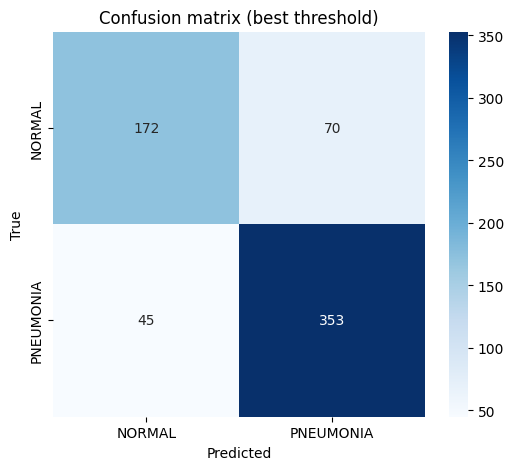

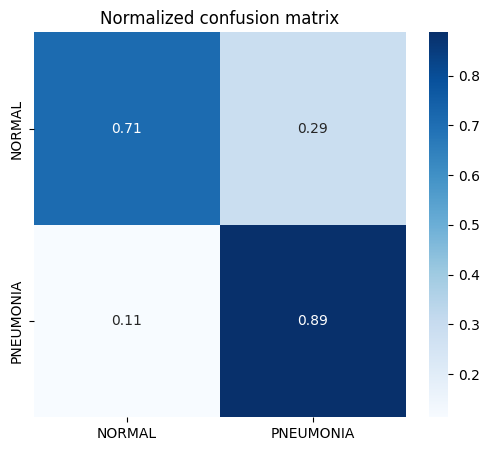

In [14]:
# Final confusion matrix with labels and normalized view
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('Confusion matrix [[tn, fp], [fn, tp]]:', [[tn, fp], [fn, tp]])


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion matrix (best threshold)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


# Optional: normalized
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Normalized confusion matrix')
plt.show()